In [60]:
import pandas as pd
import matplotlib.pyplot as plt

YEAR = 2023
CUTOFF = 400

# 1. EDA

In [140]:
df = pd.read_csv(f"stack-overflow-developer-survey-{YEAR}/survey_results_public.csv")
df = df.rename({"ConvertedCompYearly": "Salary"}, axis=1)
df.head()

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,Salary
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,3-5 times a week,60-120 minutes a day,30-60 minutes a day,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0


In [141]:
# Remove NaN values
dropped_df = df.dropna(subset=["Salary","DevType","YearsCodePro"])

# Select only full-time employment.
dropped_df["full_time"] = dropped_df["Employment"].apply(lambda x: "full-time" in str(x))
dropped_df = dropped_df[dropped_df["full_time"]]

# Group minor countires into "Other".
def remove_minor_categories(categories, cutoff):
    categories_dict = {}
    for c,value in categories.items():
        if value >= cutoff:
            categories_dict[c] = c
        else:
            categories_dict[c] = 'Other'
    return categories_dict

countries_dict = remove_minor_categories(df["Country"].value_counts(), CUTOFF)
dropped_df["Country"] = dropped_df["Country"].map(countries_dict).astype("category")
dropped_df = dropped_df[dropped_df["Country"] != "Other"]
dropped_df["Country"]
dropped_df["Country"].value_counts()

/var/folders/j1/8r_wr4953qv3wyg0svrcfb8m0000gn/T/ipykernel_45443/3097718154.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_df["full_time"] = dropped_df["Employment"].apply(lambda x: "full-time" in str(x))


Country
United States of America                                11267
Germany                                                  3401
United Kingdom of Great Britain and Northern Ireland     3216
Canada                                                   1944
India                                                    1746
France                                                   1548
Brazil                                                   1113
Netherlands                                              1086
Australia                                                1071
Spain                                                    1019
Poland                                                    958
Sweden                                                    946
Italy                                                     877
Switzerland                                               539
Denmark                                                   468
Norway                                                    457


In [142]:
# Group minor types of dev into "Other".
dev_dict = remove_minor_categories(dropped_df["DevType"].value_counts(), CUTOFF)
dropped_df["DevType"] = dropped_df["DevType"].map(dev_dict)
dropped_df["DevType"] = dropped_df["DevType"].apply(lambda x: "Other" if "Other" in x else x).astype("category")
dropped_df["DevType"].value_counts()

DevType
Developer, full-stack                            13583
Developer, back-end                               7916
Other                                             4440
Developer, front-end                              2615
Developer, desktop or enterprise applications     1978
Developer, mobile                                 1269
Engineering manager                               1176
Developer, embedded applications or devices       1133
DevOps specialist                                  828
Data scientist or machine learning specialist      827
Engineer, data                                     755
Research & Development role                        698
Cloud infrastructure engineer                      679
Senior Executive (C-Suite, VP, etc.)               601
Academic researcher                                537
Name: count, dtype: int64

In [159]:
# Change years of experience into number.
def experience2number(year):
    if year == "Less than 1 year":
        return 0
    elif year == "More than 50 years":
        return 30
    elif int(year) >= 30:
        return 30
    return year

dropped_df["YearsCodePro"] = dropped_df["YearsCodePro"].apply(experience2number).astype(int)

# Plots

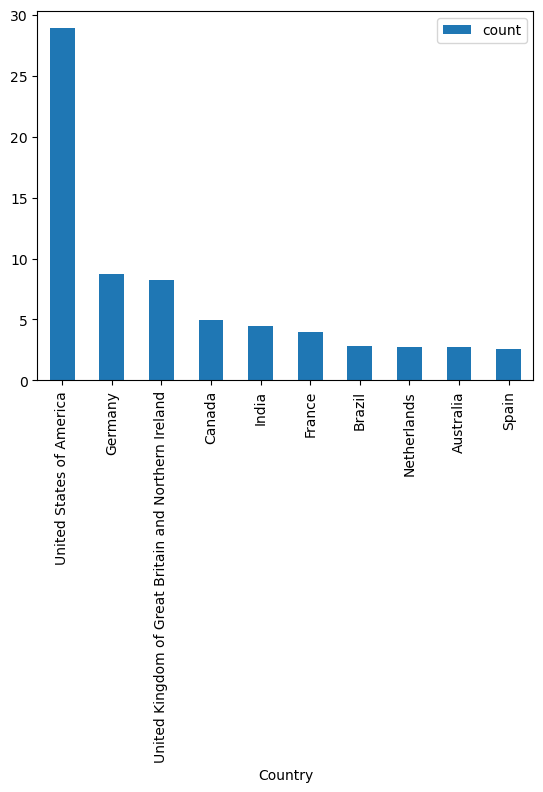

In [160]:
x = dropped_df.groupby("Country")[["Salary"]].count().rename({"Salary":"count"}, axis=1).sort_values(by="count", ascending=False).head(10)
x = x/dropped_df.shape[0]*100
x.plot.bar()
plt.show()

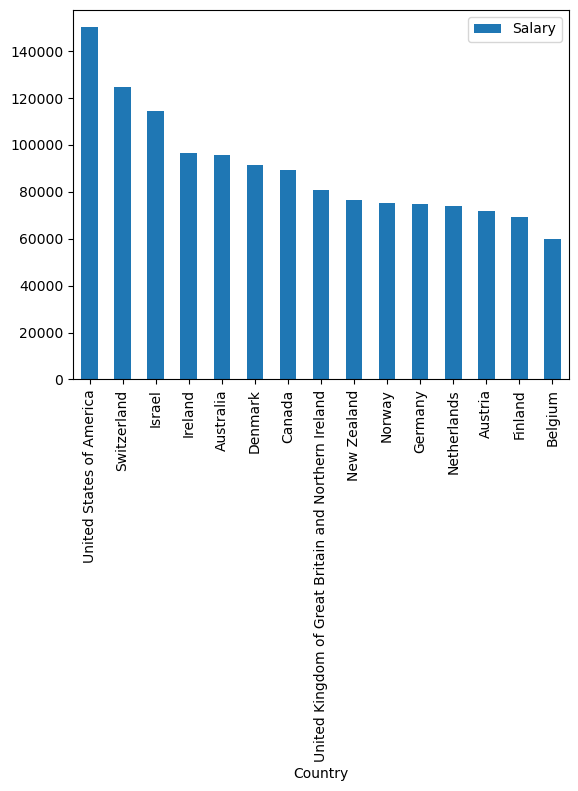

In [161]:
x = dropped_df.groupby("Country")[["Salary"]].median().sort_values(by="Salary", ascending=False).head(15)
x.plot.bar()
plt.show()

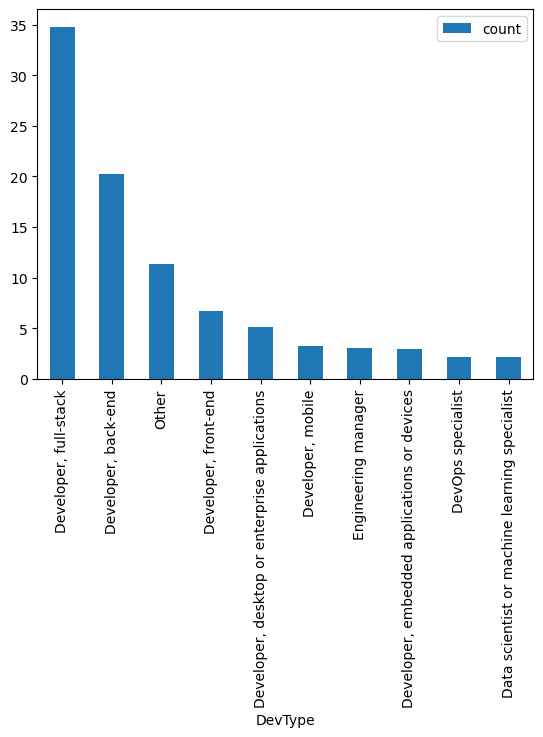

In [162]:
x = dropped_df.groupby("DevType")[["Salary"]].count().rename({"Salary":"count"}, axis=1).sort_values(by="count", ascending=False).head(10)
x = x/dropped_df.shape[0]*100
x.plot.bar()
plt.show()

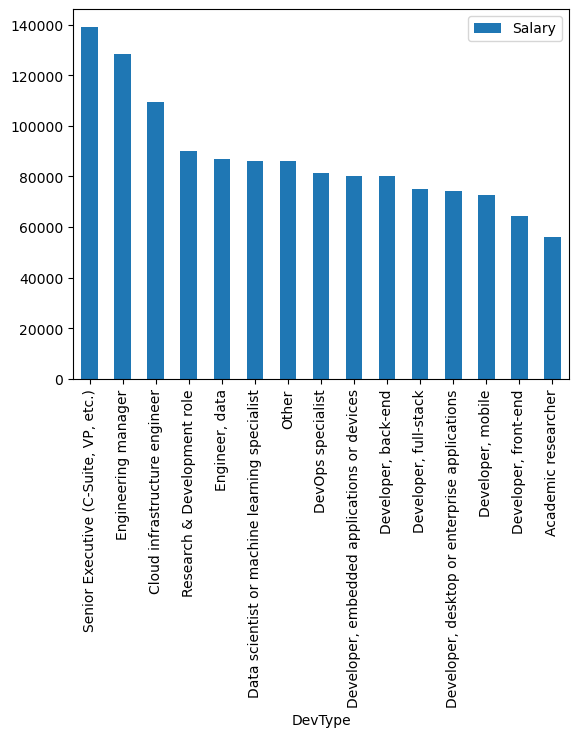

In [163]:
x = dropped_df.groupby("DevType")[["Salary"]].median().sort_values(by="Salary", ascending=False).head(15)
x.plot.bar()
plt.show()

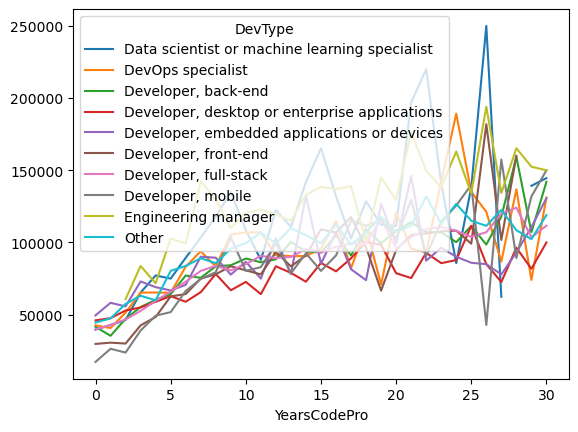

In [165]:
top_dev = list(dropped_df["DevType"].value_counts().index[:10])

x = dropped_df.groupby(["YearsCodePro","DevType"])[["Salary"]].median().reset_index()
x = x[x["DevType"].isin(top_dev)]
x = x.pivot(index="YearsCodePro", columns='DevType', values='Salary')
x.plot()
plt.show()